In [ ]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import Normalize, ToTensor, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import trange
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
image_transform = Compose([
  ToTensor(),
  Normalize((0.1307,), (0.3081,))
])

In [ ]:
def make_data_loaders(batch_size_train, batch_size_test):
  train_dataset = MNIST('dataset/', train=True, download=True, transform=image_transform)
  test_dataset = MNIST('dataset/', train=False, download=True, transform=image_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

  return train_loader, test_loader

torch.Size([1024, 1, 28, 28])
Label: tensor(5)


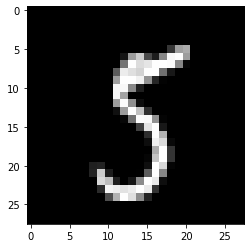

In [ ]:
train_loader, test_loader = make_data_loaders(64, 1024)
_, (data, labels) = next(enumerate(test_loader))
sample = data[0][0]
print(data.shape)
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [ ]:
# class MNISTClassifier(nn.Module):
#   def __init__(self, depth=1):
#     super(MNISTClassifier, self).__init__()
    
#     n_hidden_out = 256
#     hidden_layers = [
#         nn.Linear(784, 256),
#         nn.ReLU()
#     ]

#     if depth == 2:
#       n_hidden_out = 32
#       hidden_layers = [
#           nn.Linear(784, 512),
#           nn.ReLU(),
#           nn.Linear(512, 32),
#           nn.ReLU()
#       ]
    
#     self.flatten = nn.Flatten()
#     self.layer_stack = nn.Sequential(
#         *hidden_layers,
#         nn.Linear(n_hidden_out, 10)
#     )

#   def forward(self, x):
#     x = self.flatten(x)
#     logits = self.layer_stack(x)
#     pred = logits.argmax(1)
#     return pred



In [ ]:
def train(model, train_loader, lr, debug=False):
  epochs = 20
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()
  r = trange(epochs)
  losses = []
  for epoch in r:
    size = len(train_loader.dataset)
    batches = len(train_loader)
    for batch, (X_train, y_train) in enumerate(train_loader):
      opt.zero_grad()
      y_hat = model(X_train)
      loss = loss_fn(y_hat, y_train)
      loss.backward()
      opt.step()
      r.set_postfix(loss=f'{loss / X_train.shape[0]:.3f} | Batch {batch} of {batches}')
      if batch % 100 == 0:
        losses.append(loss.item())
        if debug == True:
          loss, current = loss.item(), batch * len(X_train)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return losses

In [ ]:
def test(model, test_loader):
  loss_fn = nn.CrossEntropyLoss()
  size = len(test_loader.dataset)
  num_batches = len(test_loader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in test_loader:
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
def make_one_layer_classifier():
  return nn.Sequential(
      nn.Flatten(),
      nn.Linear(784, 256),
      nn.ReLU(),
      nn.Linear(256, 10)
  )

In [ ]:
def make_two_layer_classifier():
  return nn.Sequential(
      nn.Flatten(),
      nn.Linear(784, 512),
      nn.ReLU(),
      nn.Linear(512, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
  )

In [ ]:
for batch_size in [10, 100, 1000, 10000]:
  for depth in [1, 2]:
    train_loader, test_loader = make_data_loaders(batch_size, batch_size)
    # model = MNISTClassifier(depth=depth)
    model = None
    if depth == 1:
      model = make_one_layer_classifier()
    else:
      model = make_two_layer_classifier()

    print(f'Batch size: {batch_size}, depth: {depth}')
    losses = train(model, train_loader, lr=0.01)
    plt.figure(figsize=(15, 10))
    plt.plot(list(range(len(losses))), losses)
    plt.title(f'Feed forward NN: batch size = {batch_size}, depth = {depth}')
    plt.show()
    test(model, test_loader)

Batch size: 10, depth: 1


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
_, test_loader = make_data_loaders(32, 60000)

_, (X_sample, y_sample) = next(enumerate(test_loader))
samples = torch.flatten(X_sample, start_dim=1)
distances = euclidean_distances(samples).ravel()
median = np.median(distances)

median

33.248936

In [ ]:
# sigmas = [median]
sigmas = [0.1, 1, 10, median]
Cs = [0.01, 0.1, 1, 10, 100]

# train_loader, test_loader = make_data_loaders(60000, 60000)
train_loader, test_loader = make_data_loaders(4096, 4096)
_, (X_train, y_train) = next(enumerate(train_loader))
_, (X_test, y_test) = next(enumerate(test_loader))
X_train = torch.flatten(X_train, start_dim=1).numpy()
y_train = y_train.numpy()
X_test = torch.flatten(X_test, start_dim=1).numpy()
y_test = y_test.numpy()

all_accuracies = []

for sigma in sigmas:
  accuracies = []
  
  for i, C in enumerate(Cs):
    gamma = 1 / (sigma**2)
    # model = make_pipeline(StandardScaler(), SVC(gamma=gamma, C=C, kernel="rbf"))
    model = SVC(gamma=gamma, C=C, kernel="rbf")
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_hat)
    accuracies.append(accuracy)
    print(f'Trained SVM: sigma = {sigma}, C = {C}: accuracy = {accuracy}')
  
  all_accuracies.append(accuracies)

Trained SVM: sigma = 0.1, C = 0.01: accuracy = 0.10302734375
Trained SVM: sigma = 0.1, C = 0.1: accuracy = 0.10302734375
Trained SVM: sigma = 0.1, C = 1: accuracy = 0.10302734375
Trained SVM: sigma = 0.1, C = 10: accuracy = 0.10302734375
Trained SVM: sigma = 0.1, C = 100: accuracy = 0.10302734375
Trained SVM: sigma = 1, C = 0.01: accuracy = 0.10302734375
Trained SVM: sigma = 1, C = 0.1: accuracy = 0.10302734375
Trained SVM: sigma = 1, C = 1: accuracy = 0.10302734375
Trained SVM: sigma = 1, C = 10: accuracy = 0.10302734375
Trained SVM: sigma = 1, C = 100: accuracy = 0.10302734375
Trained SVM: sigma = 10, C = 0.01: accuracy = 0.10302734375
Trained SVM: sigma = 10, C = 0.1: accuracy = 0.19921875
Trained SVM: sigma = 10, C = 1: accuracy = 0.8125
Trained SVM: sigma = 10, C = 10: accuracy = 0.82421875
Trained SVM: sigma = 10, C = 100: accuracy = 0.82421875
Trained SVM: sigma = 33.24893569946289, C = 0.01: accuracy = 0.395751953125
Trained SVM: sigma = 33.24893569946289, C = 0.1: accuracy = 0

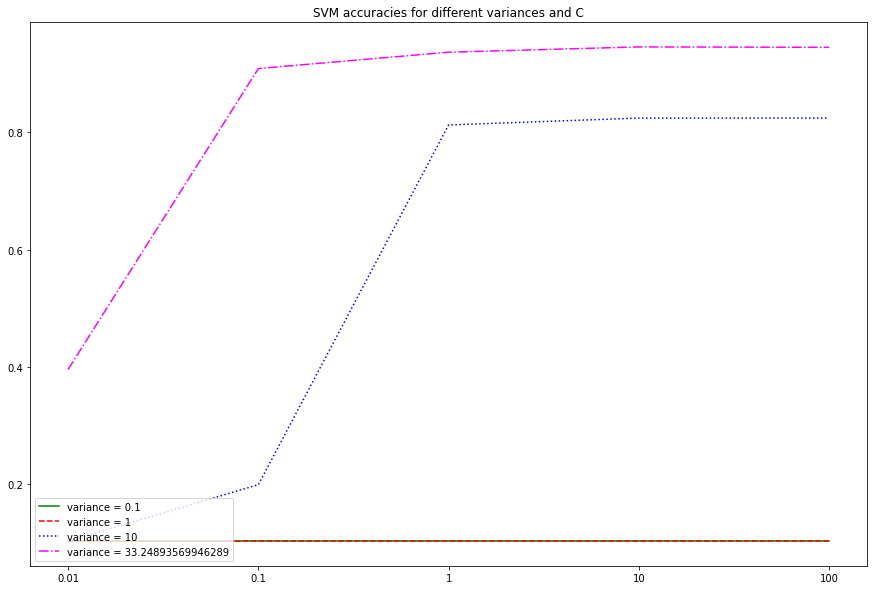

In [ ]:
colors = ['green', 'red', 'blue', 'magenta']
linestyle = ['-', '--', ':', '-.']

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for i, sigma in enumerate(sigmas):
  plt.plot(np.arange(0, len(Cs), 1), all_accuracies[i], color=colors[i], linestyle=linestyle[i], label=f'variance = {sigma}')
  ax.set_xticks([x for x in range(len(Cs))])
  ax.set_xticklabels(Cs)

plt.title("SVM accuracies for different variances and C")
plt.legend(loc="lower left")
plt.show()